Figure 7 of [Compound lensing: Einstein Zig-Zags and high multiplicity lensed images](http://adsabs.harvard.edu/abs/2016MNRAS.456.2210C)

In [1]:
# import modules and set some defaults
%matplotlib inline
import grale.plotutil as plotutil
import grale.lenses as lenses
import grale.feedback as feedback
import grale.images as images
import grale.cosmology as cosmology
from grale.constants import *
from grale.multiplane import MultiImagePlane
import numpy as np
import matplotlib.pyplot as plt
import sys
import json

V = lambda x,y: np.array([x,y], dtype=np.double)
LI = plotutil.LensInfo
cosm = cosmology.Cosmology(0.7, 0.3, 0, 0.7)

cosmology.setDefaultCosmology(cosm)
# A shorter name for this function that we'll be needing a few times
Z = cosm.getAngularDiameterDistance 

feedback.setDefaultFeedback("none")

In [2]:
zd, zd2, zs = 0.1, 1.6, 10

# In the caption of figure 7, the first SIS lens is said to have a velocity
# dispersion of 190km/s and the second of 250km/s. I found that the value
# of 245km/s better reproduces the value of alpha2.
sis = lenses.SISLens(Z(zd), { "velocityDispersion": 190000 })
sis2 = lenses.SISLens(Z(zd2), { "velocityDispersion": 245000 })

# 'beta' is defined in the article as (D_12 * D_3)/(D_2 * D_13) (note that eq (6) has a typo, 
# but this definition can be seen to be the right one from eq (5)). From the caption of
# fig 7, beta^-1 should be 1.05
beta = (Z(zd, zd2)*Z(zs))/(Z(zd2)*Z(zd, zs))
print("beta^-1", beta**-1)

# For a SIS lens the deflection is constant; to obtain it from the model we're
# just going to evaluate the deflection angle at a point on the x-axis and get
# the x-component. We also need to rescale the angle by Dds/Ds to get the values
# used in the article

alpha1 = sis.getAlphaVector([1.0, 0.0])[0]*Z(zd, zs)/Z(zs)
alpha2 = sis2.getAlphaVector([1.0, 0.0])[0]*Z(zd2, zs)/Z(zs)
# From the caption of fig 7, alpha2 should be 0.9, in the units where alpha1 is 1.
print("alpha2 (units of alpha1)", alpha2/alpha1)

# We're going to plot in units of alpha1
U = alpha1
plotutil.setDefaultAngularUnit(U)

# For the first lens, we're going to use the first SIS lens, which is already
# centered on (0,0). As we want to move the second lens to (0.9,0) (in units
# of alpha1), we'll need to use a CompositeLens for this.
lens1 = sis
lens2 = lenses.CompositeLens(Z(zd2), [{"lens": sis2, "x": 0.9*U, "y": 0, "angle": 0, "factor": 1}])

beta^-1 1.052615073620246
alpha2 (units of alpha1) 0.9024527753292862


In [3]:
# Prepare to plot a similar region as fig 7
bl = V(-1.5,-2)*U
tr = V(3.5,2)*U

lensInfo = LI([ (lens1, zd), (lens2, zd2) ], bottomleft=bl, topright=tr, zs=zs, numxy=1023)

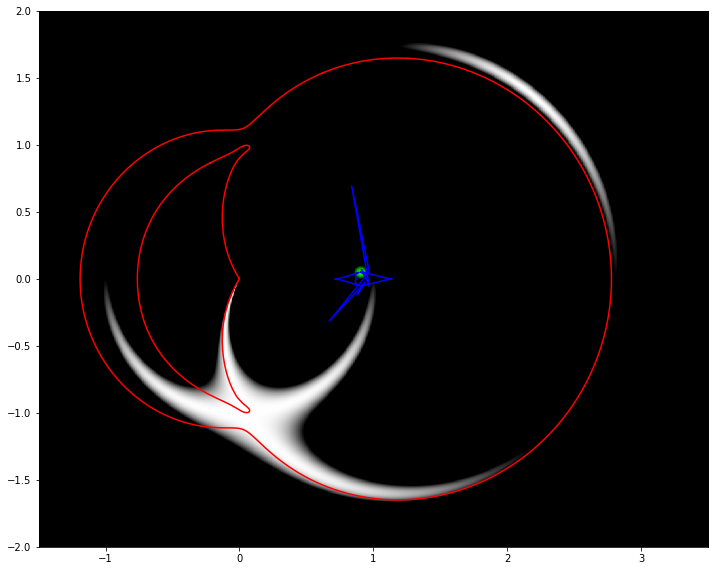

In [4]:
# From the right panel of fig 7, the source appears to be centered on (0.9, 0.05),
# with a radius of 0.05. Let's plot this situation
src = images.CircularSource(V(0.9, 0.05)*U, 0.05*U, fade=True)

plt.figure(figsize=(12,12))
plotutil.plotImagePlane(lensInfo, [src]);

In [5]:
# The odd lines are some numerical instability. To illustrate this, we'll
# make a movie that shows which point on the inner critical line corresponds
# to which point on the caustic. When the point (0,0) is reached, there are
# some larger fluctuations; otherwise the behaviour is quite smooth.
ip = lensInfo.getImagePlane()

critLines = ip.getCriticalLines()
allPoints = []
for p in critLines[1]:
    allPoints.append(p)

class MyAnim(plotutil.NotebookAnimation):
    def __init__(self, skip):
        num = len(allPoints)//skip
        super(MyAnim, self).__init__("multisis-criticalline.mp4", [0], [len(allPoints)-1], num, 25)

    def onInit(self, axes):
        pass

    def onDraw(self, pos, axes):
        
        idx = int(round(pos[0]))
        idx = min(idx,len(allPoints))
        
        axes.clear()
        # Turn off the feedback here, to avoid a clash with the feedback about
        # the frame number being rendered
        plotutil.plotImagePlane(lensInfo, axes=axes, feedbackObject="none")
        
        p = allPoints[idx]
        tx, ty = p/ANGLE_ARCSEC
        bx, by = ip.traceTheta(p)/ANGLE_ARCSEC
        axes.plot([tx, bx], [ty,by], '-', color='white')
        axes.set_xlim([-1,2])
        axes.set_ylim([-1.5,1.5])        

In [6]:
plt.figure(figsize=(12,12))
MyAnim(1);

FloatProgress(value=1.0, max=2587.0, min=1.0)

Text(value='')

In [7]:
# This instability is actually resolved if we don't use a SIS, but an
# NSIS, the non-singular version. The following animation illustrates
# the effect for different core radii

In [8]:
class MyAnim2(plotutil.NotebookAnimation):
    def __init__(self, startCore, stopCore, steps):
        super(MyAnim2, self).__init__("multisis-coreeffect.mp4", [np.log(startCore)], 
                                      [np.log(stopCore)], steps, 25)

    def onInit(self, axes):
        pass

    def onDraw(self, pos, axes):
        c = np.exp(pos[0])
        lens1 = lenses.NSISLens(Z(zd), { "velocityDispersion": 190000, "coreRadius": c })
        lens2 = lenses.CompositeLens(Z(zd2), [
            {"lens": lenses.NSISLens(Z(zd2), { "velocityDispersion": 245000, "coreRadius": c }),
             "x": 0.9*U, "y": 0, "angle": 0, "factor": 1}])

        lensInfo2 = LI([ (lens1, zd), (lens2, zd2) ], bottomleft=bl, topright=tr, zs=zs, numxy=1023)

        axes.clear()
        plotutil.plotImagePlane(lensInfo2, [src], feedbackObject="none", axes=axes);
        axes.set_title("Core = {:.4f} arcsec".format(c/ANGLE_ARCSEC))

In [9]:
plt.figure(figsize=(10,10))
a = MyAnim2(0.1*ANGLE_ARCSEC, 0.0001*ANGLE_ARCSEC, 250)

FloatProgress(value=1.0, max=250.0, min=1.0)

Text(value='')